<a href="https://colab.research.google.com/github/hamxathirr/Predictive_of_Products_Price_from_Amazon_DataSet/blob/master/Predictive_of_Products_Price_from_Amazon_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-alpha0 keras

     |████████████████████████████████| 79.9 MB 63.4 MB/s 
     |████████████████████████████████| 411 kB 45.2 MB/s 
     |████████████████████████████████| 3.0 MB 32.8 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [0]:
# dataframe
import pandas as pd
import numpy as np

import time

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#Library for building wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import wordpunct_tokenize

# XGB
import xgboost as xgb
# cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding


# For displaying images in ipython
import seaborn as sns
sns.set(color_codes = True)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [0]:
print(tf.__version__)

2.0.0-alpha0


## Predicting the categories of the items

In [0]:
# import the dataset
df = pd.read_csv('../input/saved.csv')

In [0]:
df.head(2)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,average_review_rating,customers_who_bought_this_item_also_bought,total_suggested_items,description,have_product_description,have_product_description.1,product_information,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,4.446,5 new,15.0,1.0,Hobbies > Model Trains & Railway Sets > Rail V...,4.9,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,6.0,Product Description Hornby 2014 Catalogue Box ...,True,True,Technical Details Item Weight640 g Product Dim...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,22.087,NaN,2.0,1.0,Hobbies > Model Trains & Railway Sets > Rail V...,4.5,http://www.amazon.co.uk/Christmas-Holiday-Expr...,6.0,Size Name:Large FunkyBuys® Large Christmas Hol...,True,True,Technical Details Manufacturer recommended age...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 19 columns):
uniq_id                                        10002 non-null object
product_name                                   10002 non-null object
manufacturer                                   9995 non-null object
price                                          10002 non-null float64
number_available_in_stock                      7502 non-null object
number_of_reviews                              9984 non-null object
number_of_answered_questions                   9237 non-null object
amazon_category_and_sub_category               9312 non-null object
average_review_rating                          10002 non-null float64
customers_who_bought_this_item_also_bought     8940 non-null object
total_suggested_items                          8940 non-null float64
description                                    9351 non-null object
have_product_description                       10002 non-null bool
h

In [0]:
df2 = df[['product_name', 'amazon_category_and_sub_category']]

In [0]:
# droping the null values from df2
df2 = df2.dropna(how='any',axis=0)
df2.reset_index(drop=True, inplace=True)

In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9312 entries, 0 to 9311
Data columns (total 2 columns):
product_name                        9312 non-null object
amazon_category_and_sub_category    9312 non-null object
dtypes: object(2)
memory usage: 145.6+ KB


In [0]:
# split the amazon_category_and_sub_category column into several different categories levels
levels = df2['amazon_category_and_sub_category'].str.split('>')
levels

0       [Hobbies ,  Model Trains & Railway Sets ,  Rai...
1       [Hobbies ,  Model Trains & Railway Sets ,  Rai...
2       [Hobbies ,  Model Trains & Railway Sets ,  Rai...
3       [Hobbies ,  Model Trains & Railway Sets ,  Rai...
4       [Hobbies ,  Model Trains & Railway Sets ,  Rai...
                              ...                        
9307    [Hobbies ,  Collectible Figures & Memorabilia ...
9308           [Characters & Brands ,  Star Wars ,  Toys]
9309    [Novelty & Special Use ,  Novelty ,  Accessori...
9310    [Hobbies ,  Collectible Figures & Memorabilia ...
9311           [Characters & Brands ,  Star Wars ,  Toys]
Name: amazon_category_and_sub_category, Length: 9312, dtype: object

In [0]:
# iterate through each list and separate the cat labels
level_list = [l for l in levels]

Predicting multiple classes requires a lot of computauion and time. In order to save time and cost and get better accuracy we will predict only main category.

In [0]:
levels_df = pd.DataFrame(level_list, columns=['level0', 'level1', 'level2', 'level3', 'level4'])
levels_df

,level0,level1,level2,level3,level4
0,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
1,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
2,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
3,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
4,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
...,...,...,...,...,...
9307,Hobbies,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,None,None
9308,Characters & Brands,Star Wars,Toys,None,None
9309,Novelty & Special Use,Novelty,Accessories,Buttons & Pins,None
9310,Hobbies,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,None,None


In [0]:
# now merge two dataframes
df2.drop(['amazon_category_and_sub_category'],axis=1,inplace=True)
df2 = pd.concat([df2, levels_df], axis=1)
df2.head(500)

,product_name,level0,level1,level2,level3,level4
0,Hornby 2014 Catalogue,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
1,FunkyBuys® Large Christmas Holiday Express Fes...,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
...,...,...,...,...,...,...
495,Lanyard With Mickey Ears Dangle - Disney's Mic...,Characters & Brands,Disney,Toys,None,None
496,Motion Sand® Castle Bucket Playset,Arts & Crafts,Art Sand,None,None,None
497,"Playmobil - 4160 Advent Calendar ""Dragon's Land""",Figures & Playsets,Knights & Castles,None,None,None
498,"Kinetic Sand, 1lb (454g) Shimmering Blue Sapphire",Arts & Crafts,Art Sand,None,None,None


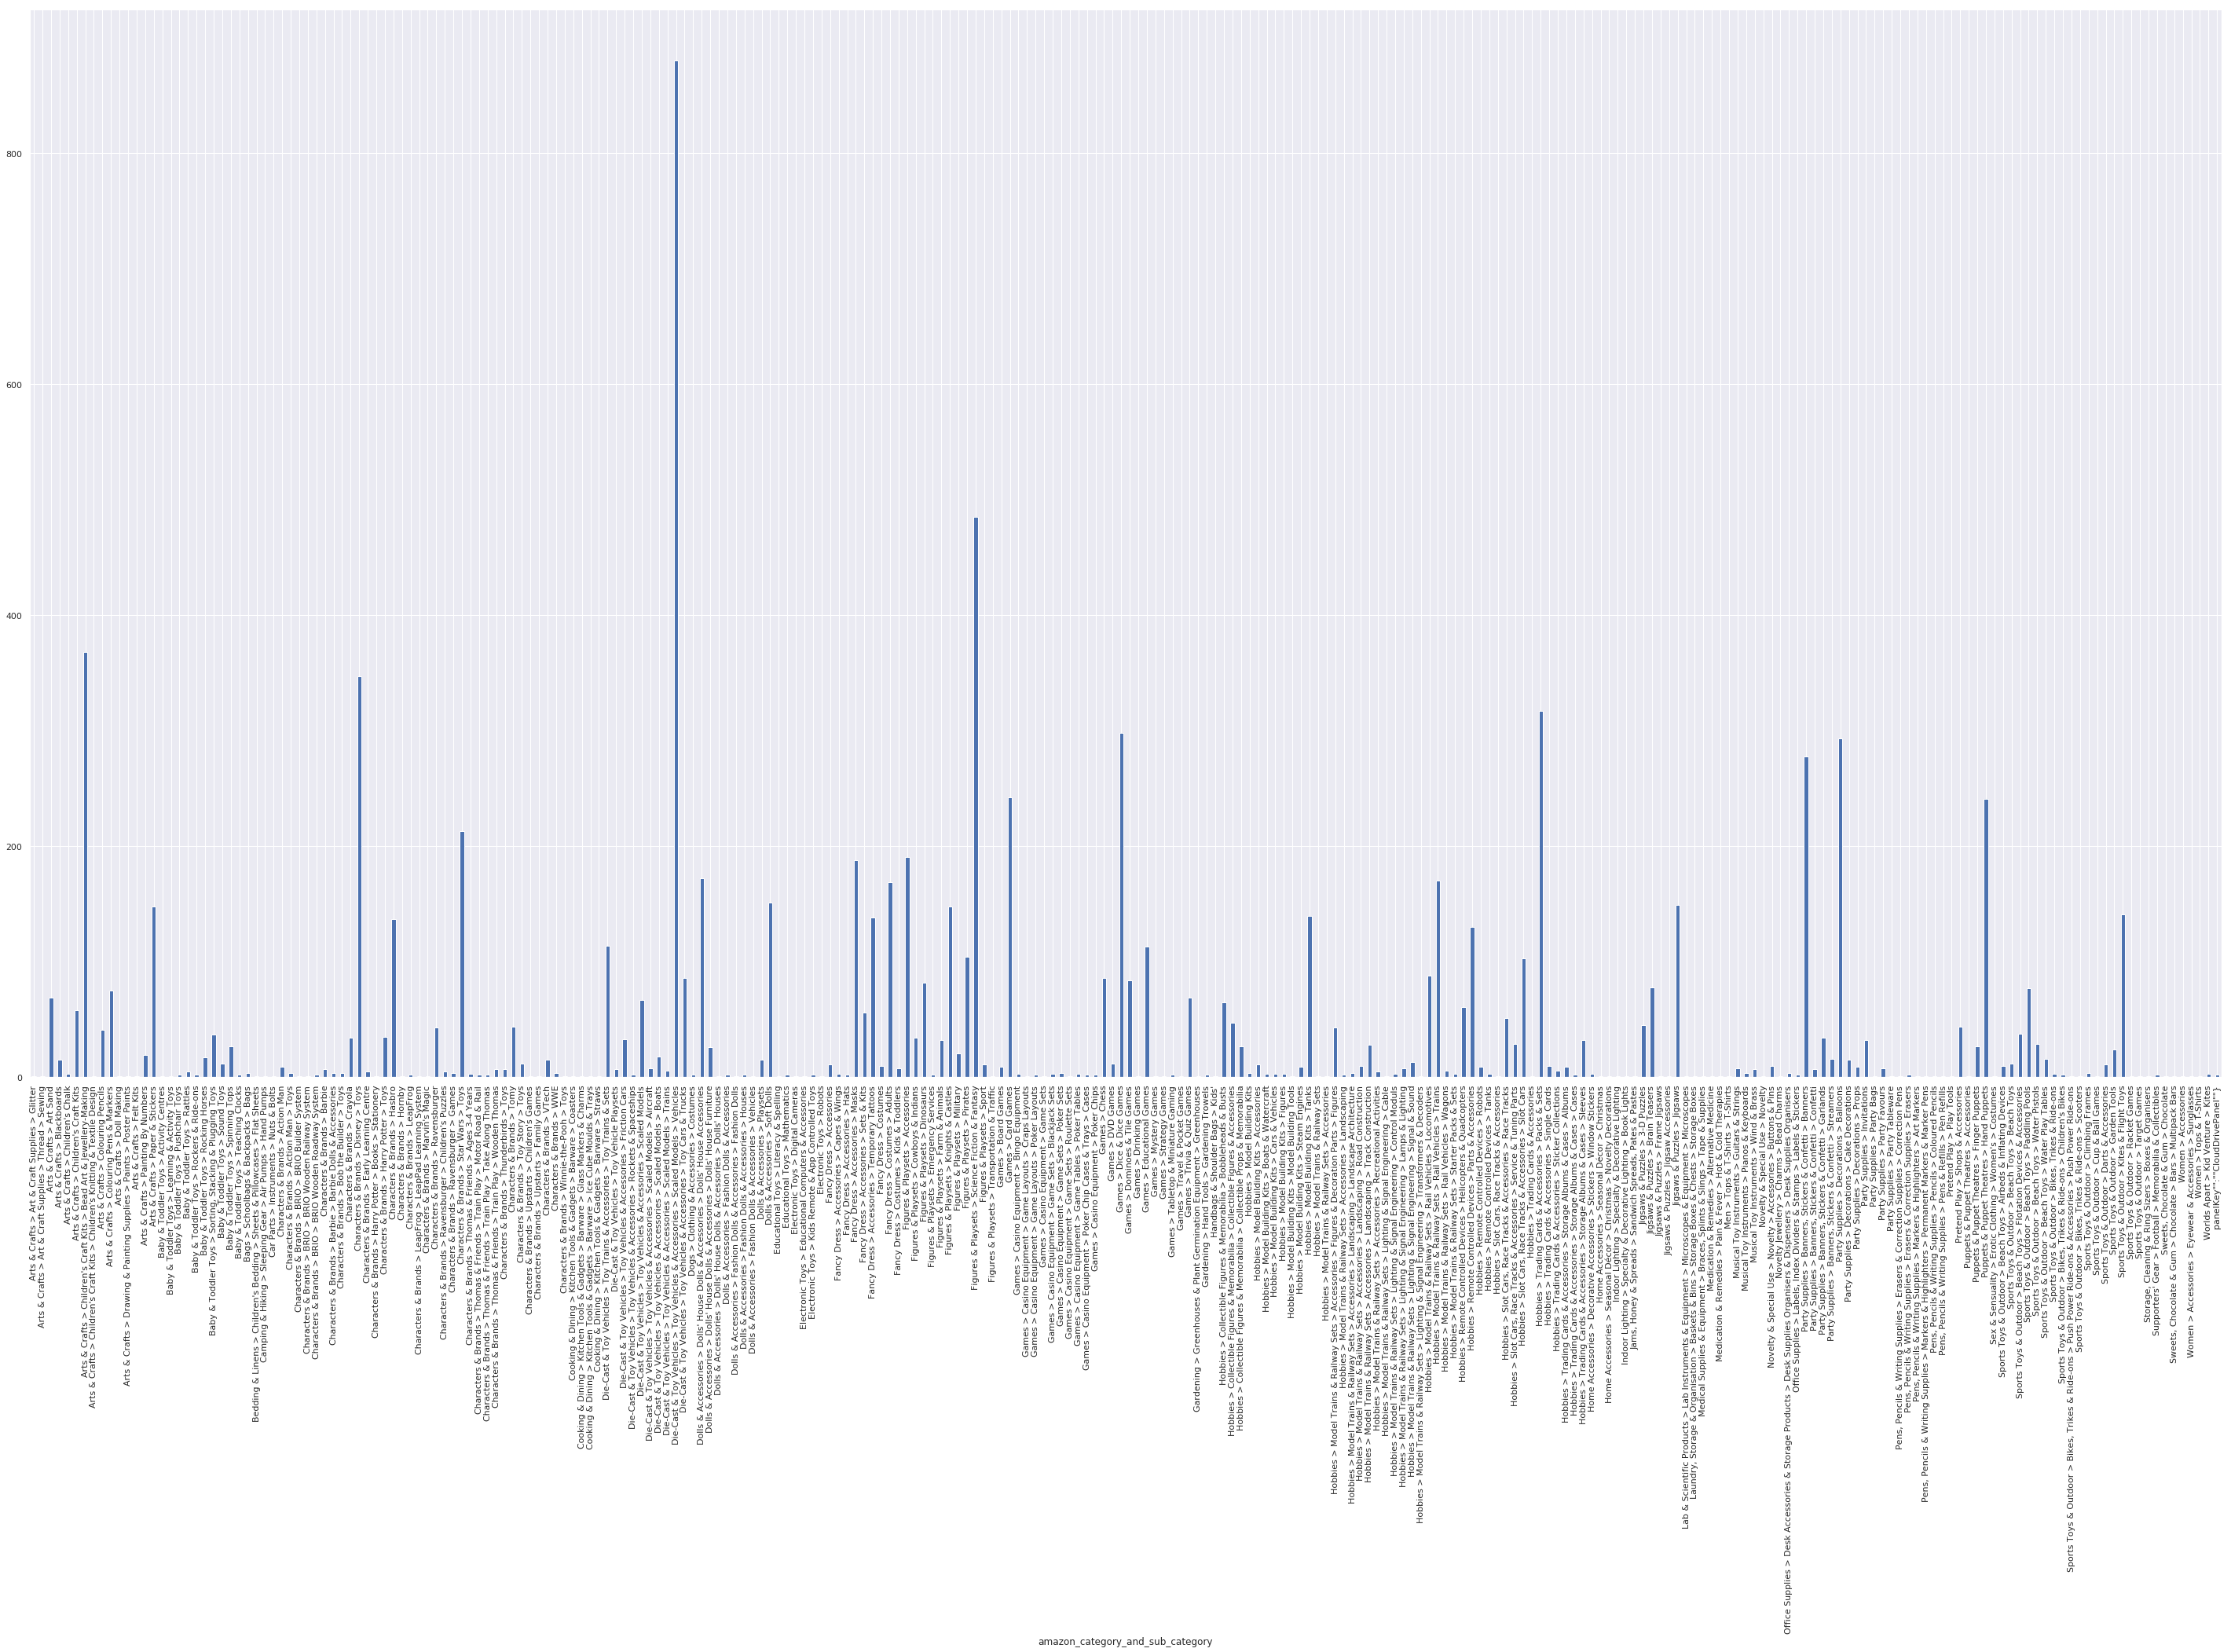

In [0]:
#Combine plot for cat and sub cat
fig = plt.figure(figsize=(50,25))
df.groupby('amazon_category_and_sub_category').product_name.count().plot.bar(ylim=0)
plt.show()

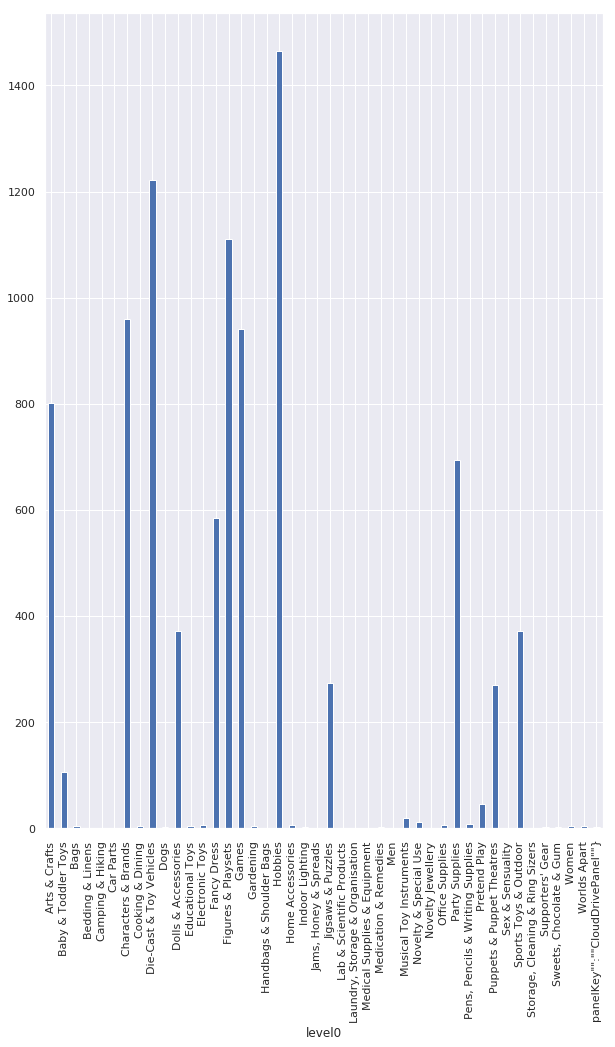

In [0]:
# separate plot for cat level 0
fig = plt.figure(figsize=(10,15))
df2.groupby('level0').product_name.count().plot.bar(ylim=0)
plt.show()

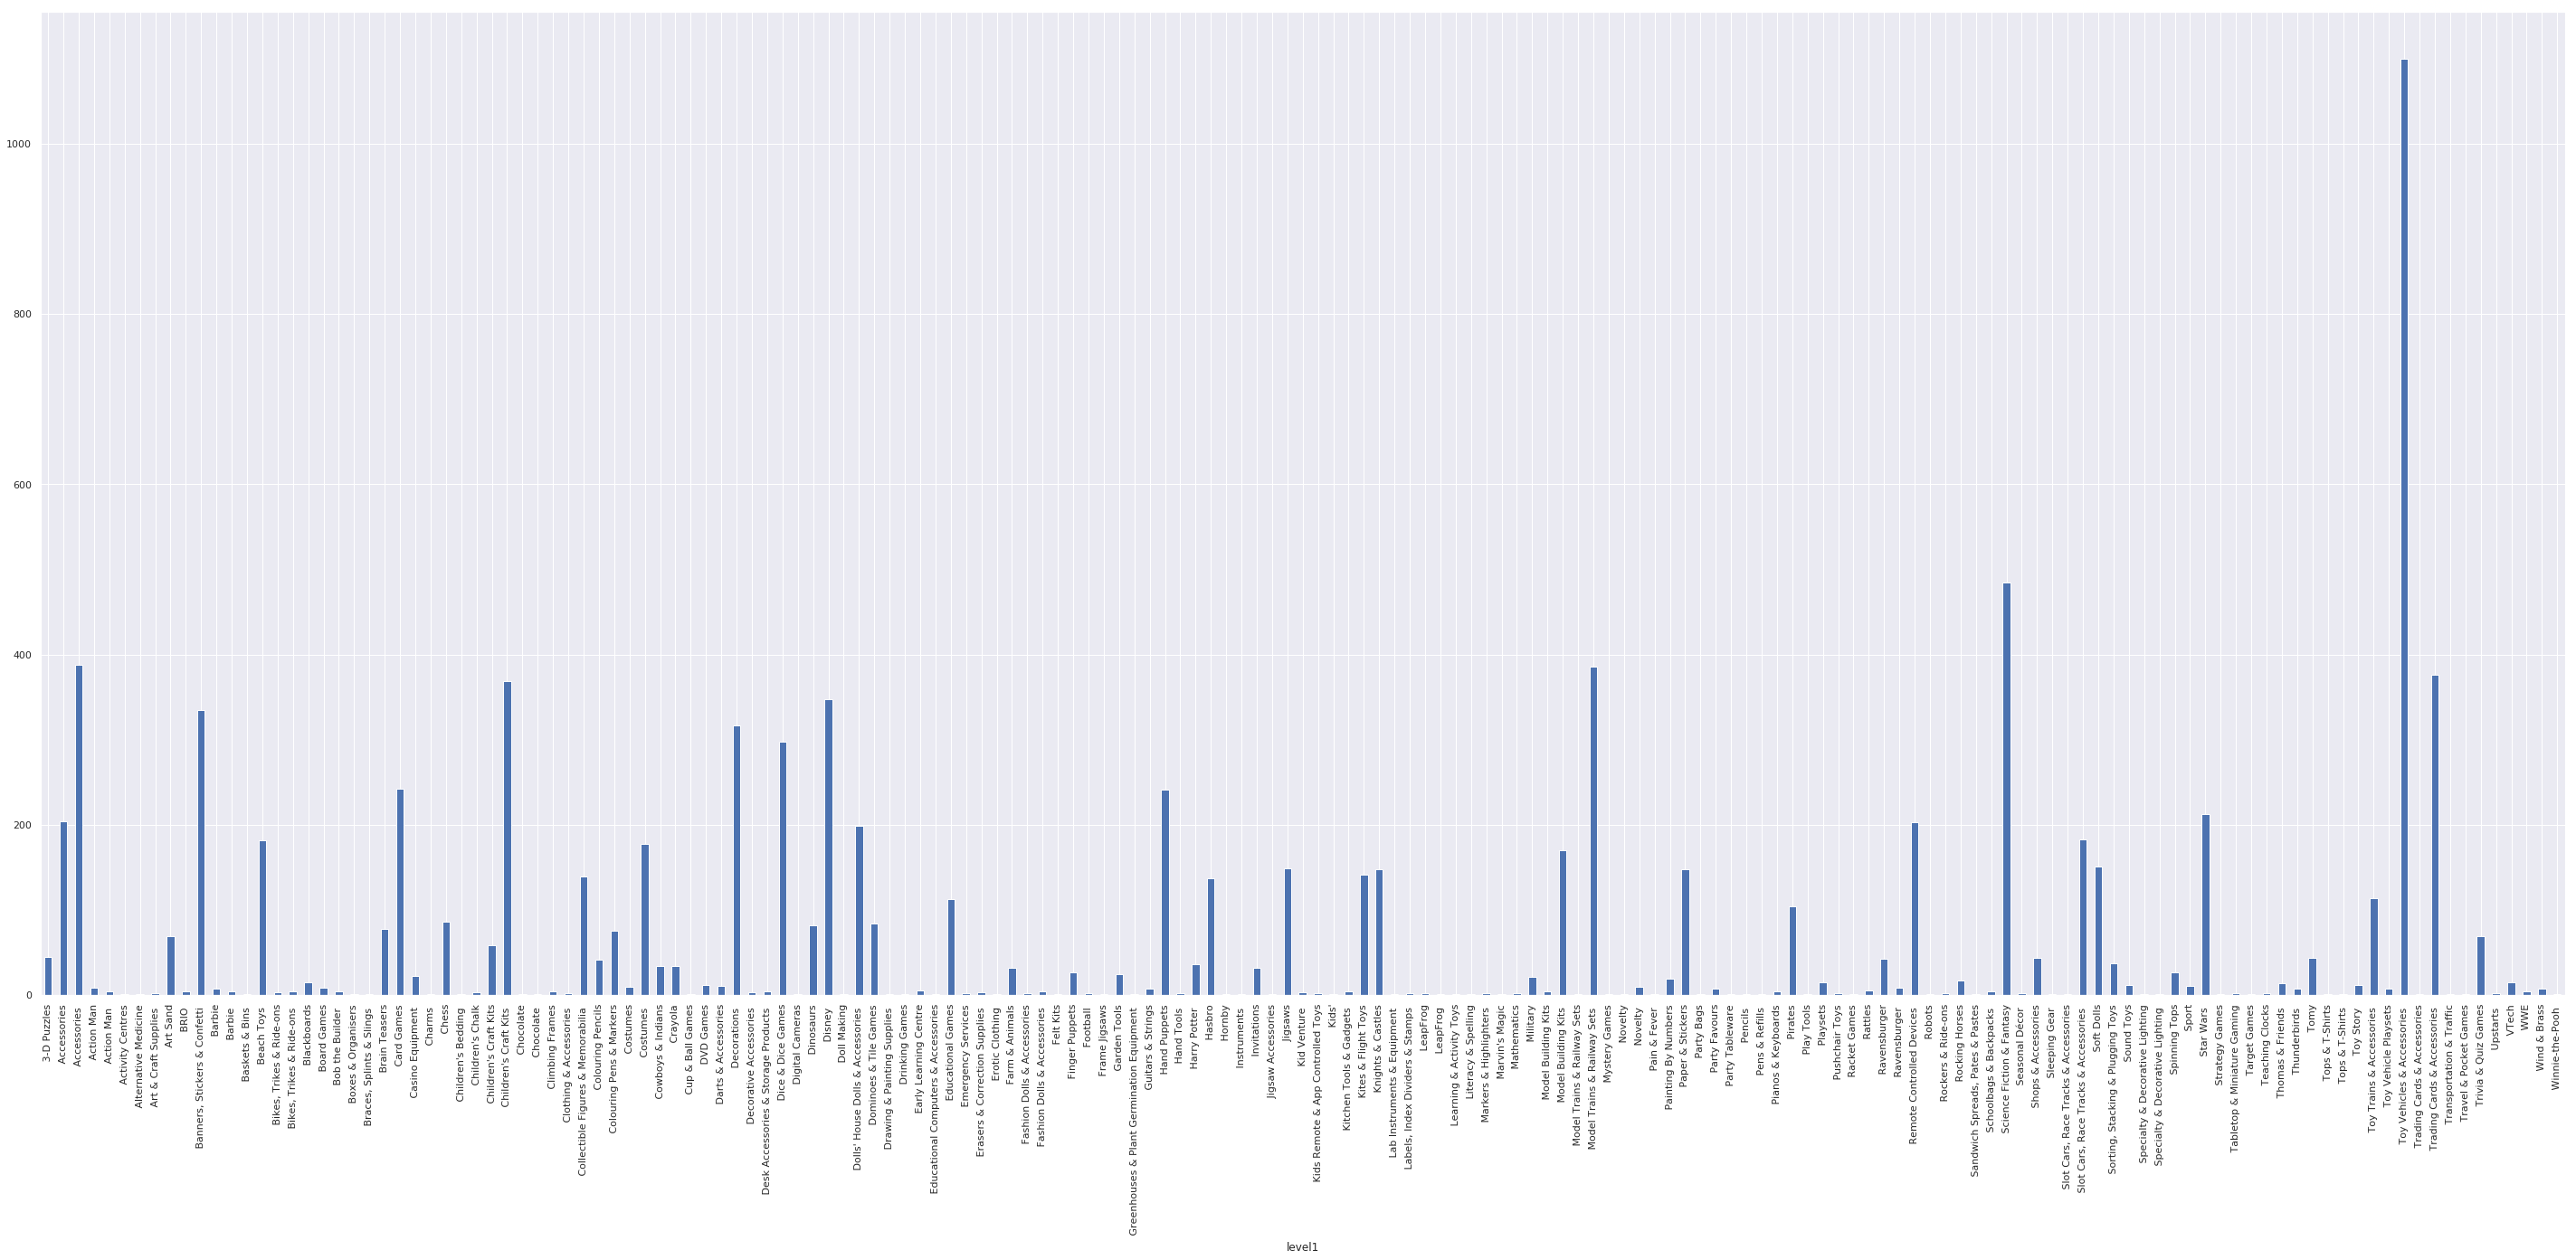

In [0]:
# separate plot for cat level 1
fig = plt.figure(figsize=(50,20))
df2.groupby('level1').product_name.count().plot.bar(ylim=0)
plt.show()

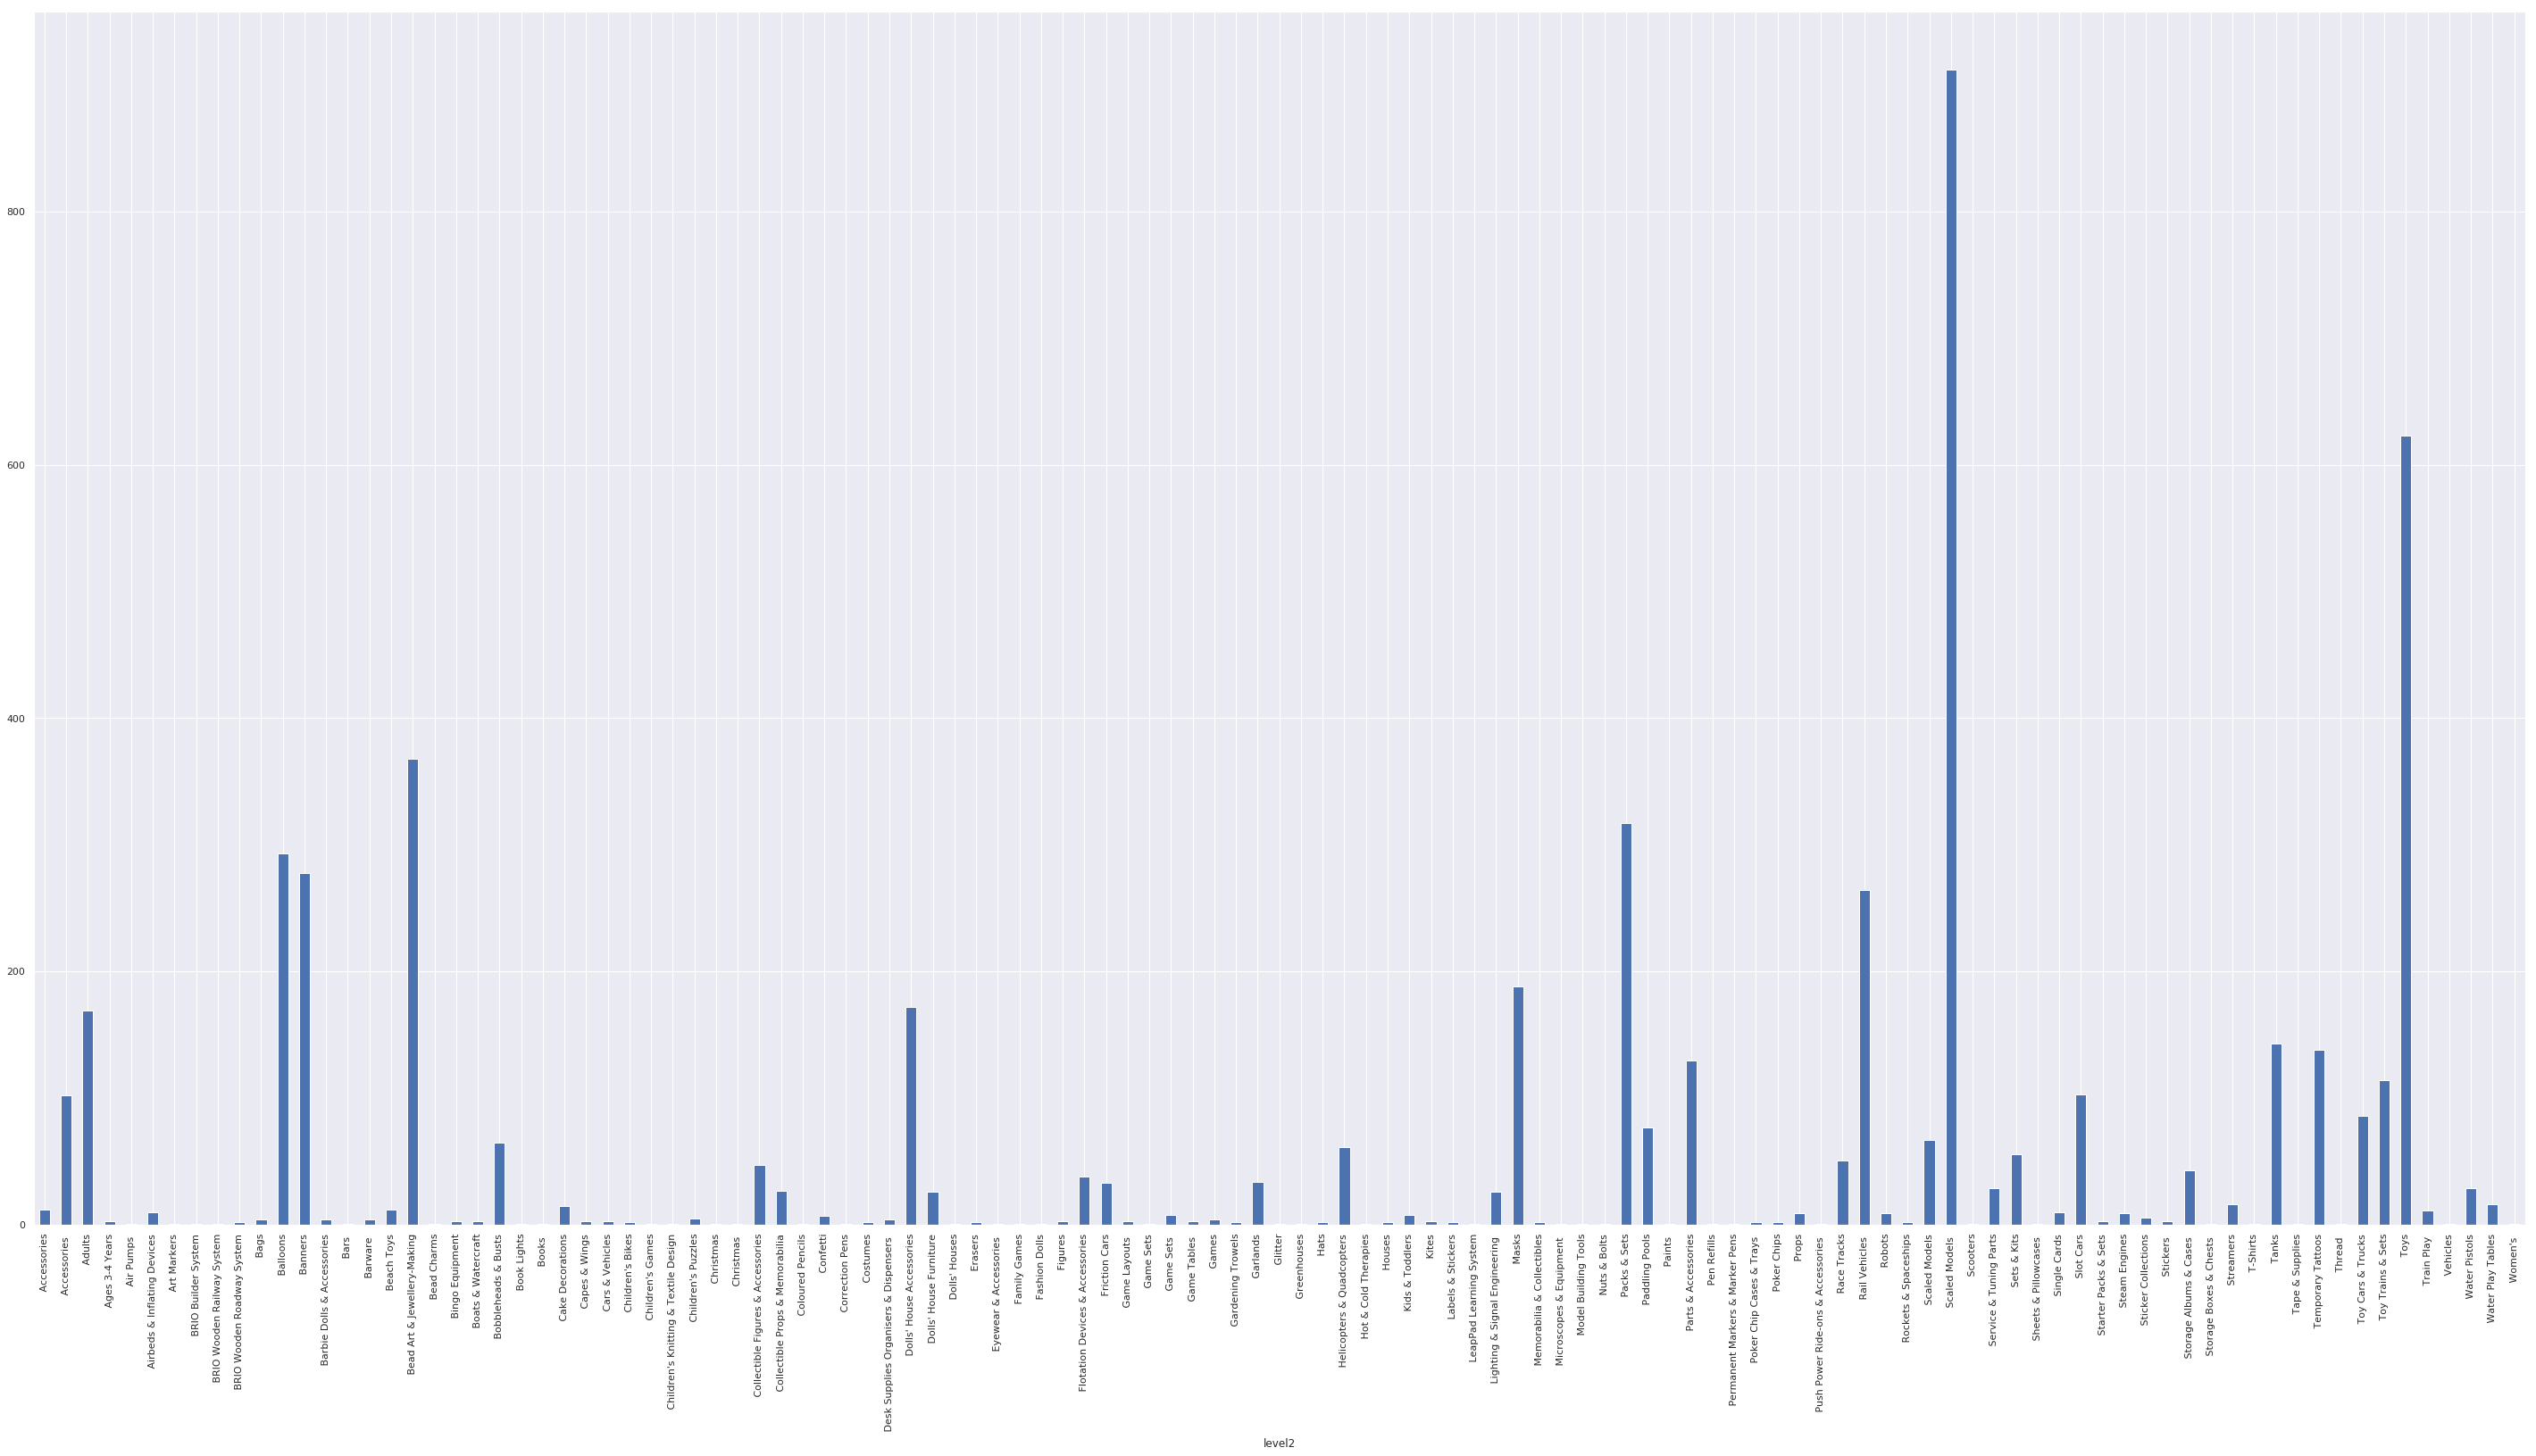

In [0]:
# separate plot for cat level 2
fig = plt.figure(figsize=(50,25))
df2.groupby('level2').product_name.count().plot.bar(ylim=0)
plt.show()

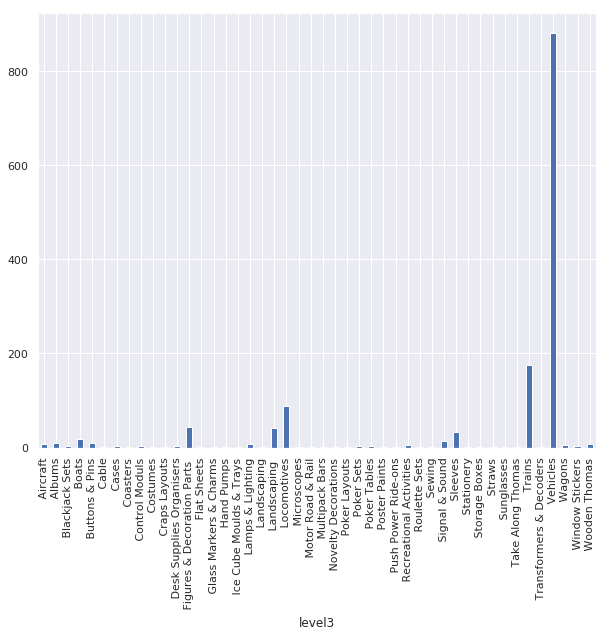

In [0]:
# separate plot for cat level 3
fig = plt.figure(figsize=(10,8))
df2.groupby('level3').product_name.count().plot.bar(ylim=0)
plt.show()

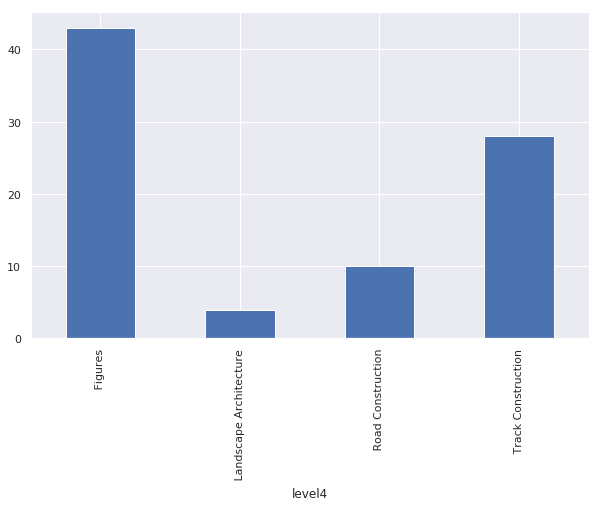

In [0]:
# separate plot for cat level 4
fig = plt.figure(figsize=(10,6))
df2.groupby('level4').product_name.count().plot.bar(ylim=0)
plt.show()

In [0]:
df2['level0'].value_counts()

Hobbies                              1464
Die-Cast & Toy Vehicles              1221
Figures & Playsets                   1111
Characters & Brands                   960
Games                                 941
Arts & Crafts                         802
Party Supplies                        694
Fancy Dress                           585
Sports Toys & Outdoor                 372
Dolls & Accessories                   371
Jigsaws & Puzzles                     274
Puppets & Puppet Theatres             269
Baby & Toddler Toys                   106
Pretend Play                           45
Musical Toy Instruments                19
Novelty & Special Use                  11
Pens, Pencils & Writing Supplies        7
Office Supplies                         6
Electronic Toys                         5
Home Accessories                        5
Cooking & Dining                        4
Bags                                    4
Worlds Apart                            3
Educational Toys                  

### Dummies

Pandas get_dummies method is a very straight forward one step procedure to get the dummy variables for categorical features.

In [0]:
oneHot = pd.get_dummies(df2['level0'], prefix_sep='_')
df3 = pd.DataFrame()
df3 = pd.concat([df2['product_name'], oneHot], axis=1)

In [0]:
df3 = df3[:9000]

In [0]:
df3.shape

(9000, 45)

Data preprocessing

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df3["product_name"].values, df3.drop(['product_name'],axis=1).values, test_size=0.2, random_state=42)

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((7200,), (7200, 44), (1800,), (1800, 44))

In [0]:
len(y_test[0])

44

In [0]:
# hyper parameters
vocab_size = 9000
embedding_dim = 64
max_length = 50
training_portion = .8

In [0]:
tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_length)

In [0]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_length)

In [0]:
X_train.shape

(7200, 50)

In [0]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 9000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(44, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          576000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 44)                2860      
Total params: 653,164
Trainable params: 653,164
Non-trainable params: 0
_________________________________________________________________


## Fit Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
len(X_train), len(y_train)

(7200, 7200)

In [0]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=35,
                    verbose=1,
                    validation_split=0.1)

Train on 6480 samples, validate on 720 samples
Epoch 1/35
6480/6480 [==============================] - 6s 898us/sample - loss: 3.7567 - accuracy: 0.1105 - val_loss: 3.6926 - val_accuracy: 0.1514
Epoch 2/35
6480/6480 [==============================] - 5s 744us/sample - loss: 3.5835 - accuracy: 0.1336 - val_loss: 3.2597 - val_accuracy: 0.1514
Epoch 3/35
6480/6480 [==============================] - 5s 844us/sample - loss: 2.9817 - accuracy: 0.1400 - val_loss: 2.7685 - val_accuracy: 0.1375
Epoch 4/35
6480/6480 [==============================] - 5s 847us/sample - loss: 2.6455 - accuracy: 0.1659 - val_loss: 2.5545 - val_accuracy: 0.1375
Epoch 5/35
6480/6480 [==============================] - 5s 739us/sample - loss: 2.5257 - accuracy: 0.1676 - val_loss: 2.5003 - val_accuracy: 0.2264
Epoch 6/35
6480/6480 [==============================] - 5s 773us/sample - loss: 2.4815 - accuracy: 0.1986 - val_loss: 2.4961 - val_accuracy: 0.1375
Epoch 7/35
6480/6480 [==============================] - 5s 727us/

In [0]:
score = model.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

1800/1800 [==============================] - 1s 292us/sample - loss: 1.3228 - accuracy: 0.7217
Test accuracy: 0.7216667


In [0]:
preds = model.predict(X_test)
preds.shape, y_test.shape

((1800, 44), (1800, 44))

In [0]:
mat = classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1))
print(mat)

              precision    recall  f1-score   support

           0       0.75      0.81      0.77       149
           1       0.00      0.00      0.00        25
           5       0.00      0.00      0.00         1
           6       0.61      0.69      0.65       192
           7       0.00      0.00      0.00         2
           8       0.80      0.83      0.81       246
          10       0.76      0.68      0.72        71
          12       0.00      0.00      0.00         1
          13       0.82      0.81      0.81       111
          14       0.68      0.74      0.70       219
          15       0.66      0.73      0.69       151
          18       0.73      0.72      0.73       266
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.67      0.42      0.52        66
          24       0.00      0.00      0.00         1
          25       0.00    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
np.argmax(y_test,axis=1)

array([10,  0,  8, ..., 37,  8, 31])

In [0]:
# conf_mat = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(preds,axis=1))
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=df2.level0.unique(), yticklabels=df2.level0.unique())
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()


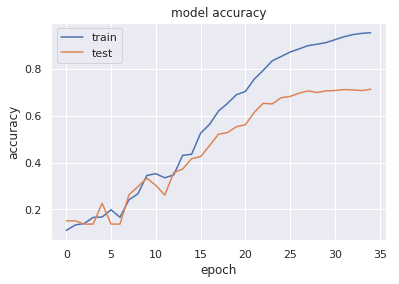

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

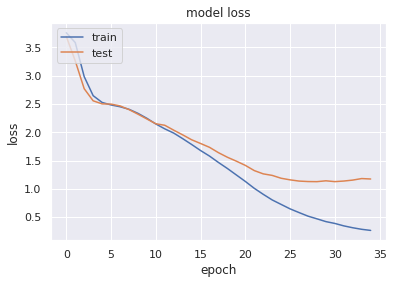

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()